In [4]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

In [5]:
# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.8.1
0.9.1


In [6]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

In [7]:
mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])
# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

We have two convolution layers, each with 5x5 kernels. After each convolution layer, we have a max-pooling layer with a stride of 2. This allows us to extract the necessary features from the images. Then we flatten the tensors and put them into a dense layer, pass through a Multi-Layer Perceptron (MLP) to carry out the task of classification of our 10 categories.

Once the layer is defined, we can then use the layer itself to compute the forward results of each layer, coupled with the activation function(ReLu) and Max Pooling operations, we can easily write the forward function of our network as above. Notice that on fc1(Fully Connect layer 1), we used PyTorch’s tensor operation t.reshape to flatten the tensor so it can be passed to the dense layer afterward. Also, we didn’t add the softmax activation function at the output layer since PyTorch’s CrossEntropy function will take care of that for us.

In [8]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [9]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [10]:
# import modules to build RunBuilder and RunManager helper classes
from collections  import OrderedDict
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

RunManager
There are four main purposes of the RunManager class. Calculate and record the duration of each epoch and run. Calculate the training loss and accuracy of each epoch and run. Record the training data (e.g. loss, accuracy, weights, gradients, computational graph, etc.) for each epoch and run, then export them into Tensor Board for further analysis. Save all training results in csv and json for future reference or API extraction. As you can see, it helps us take care of the logistics which is also important for our success in training the model.

In [11]:
# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further a
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

# Training

In [12]:
#Finally, we are ready to do some training! With the help of our RunBuilder and RunManager classes, the training process is a breeze:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [False]
)
epochs = 5

In [13]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(trainset, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.586626,0.778783,38.787914,39.345422,0.010,100,False
1,1,2,0.409067,0.850033,41.343873,80.959597,0.010,100,False
2,1,3,0.376062,0.860700,37.943559,119.202349,0.010,100,False
3,1,4,0.364023,0.866600,40.178173,159.627860,0.010,100,False
4,1,5,0.353411,0.868583,40.223282,200.062972,0.010,100,False
5,2,1,0.856523,0.680433,36.631392,39.010616,0.010,1000,False
6,2,2,0.464323,0.824233,37.152169,76.479937,0.010,1000,False
7,2,3,0.395225,0.854633,33.840515,110.565817,0.010,1000,False
8,2,4,0.355878,0.868183,34.085477,144.867715,0.010,1000,False
9,2,5,0.324166,0.880517,33.336145,178.487104,0.010,1000,False


In [14]:
# helper function to calculate all predictions of train set
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat(
        (all_preds, preds),
        dim = 0
    )
  return all_preds

In [15]:
# bigger batch size since we only do FP
prediction_loader = torch.utils.data.DataLoader(trainset, batch_size=1000)
train_preds = get_all_preds(network, prediction_loader)

In [16]:
!pip install scikit-plot

In [17]:
# use scikitplot to plot the confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

cm = confusion_matrix(trainset.targets, train_preds.argmax(dim=1))
cm

array([[5064,   11,   75,  335,   41,   12,  418,    0,   44,    0],
       [   2, 5793,    7,  130,   26,    2,   39,    0,    1,    0],
       [  63,    4, 4021,   49, 1051,    8,  782,    0,   22,    0],
       [ 219,   54,   22, 5322,  174,    2,  204,    0,    3,    0],
       [  10,   11,  619,  258, 4633,    1,  456,    0,   11,    1],
       [   1,    2,    1,    6,    0, 5747,    1,  161,   16,   65],
       [1289,   18,  892,  211,  703,    1, 2838,    0,   47,    1],
       [   0,    0,    0,    0,    0,  420,    0, 5120,    8,  452],
       [  39,    5,   56,   72,   47,   62,  161,   17, 5532,    9],
       [   0,    2,    0,    3,    0,   90,    0,  171,    6, 5728]],
      dtype=int64)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

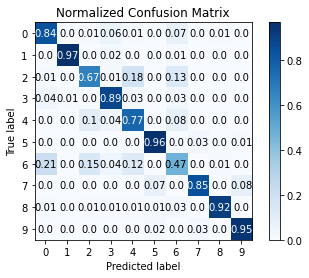

In [18]:
skplt.metrics.plot_confusion_matrix(trainset.targets,train_preds.argmax(dim=1), normalize=True)